In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
base = pd.read_csv('petr4_treinamento.csv')
base.dropna(inplace=True)
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [3]:
base_treinamento = base['Close'].values
base_treinamento

array([19.690001, 20.4     , 20.43    , ..., 16.049999, 16.1     ,
       16.1     ])

In [4]:
base_valor_maximo = base['High'].values
base_valor_maximo

array([20.209999, 20.4     , 20.620001, ..., 16.139999, 16.129999,
       16.1     ])

In [9]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento.reshape(-1,1))
base_treinamento_normalizada.shape

(1242, 1)

In [8]:
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo.reshape(-1,1))
base_valor_maximo_normalizada.shape

(1242, 1)

In [10]:
previsores = []
preco_real1 = []
preco_real2 = []

for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real1.append(base_treinamento_normalizada[i, 0])
    preco_real2.append(base_valor_maximo_normalizada[i, 0])

In [11]:
previsores, preco_real1, preco_real2 = np.array(previsores), np.array(preco_real1), np.array(preco_real2)
previsores

array([[0.76080559, 0.79567784, 0.79715132, ..., 0.75392926, 0.75491163,
        0.76375249],
       [0.79567784, 0.79715132, 0.77996075, ..., 0.75491163, 0.76375249,
        0.77062867],
       [0.79715132, 0.77996075, 0.75147351, ..., 0.76375249, 0.77062867,
        0.7858547 ],
       ...,
       [0.46954816, 0.47151279, 0.47544207, ..., 0.56728883, 0.56728883,
        0.57809433],
       [0.47151279, 0.47544207, 0.47495091, ..., 0.56728883, 0.57809433,
        0.58202356],
       [0.47544207, 0.47495091, 0.47396859, ..., 0.57809433, 0.58202356,
        0.5844794 ]])

In [12]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores

array([[[0.76080559],
        [0.79567784],
        [0.79715132],
        ...,
        [0.75392926],
        [0.75491163],
        [0.76375249]],

       [[0.79567784],
        [0.79715132],
        [0.77996075],
        ...,
        [0.75491163],
        [0.76375249],
        [0.77062867]],

       [[0.79715132],
        [0.77996075],
        [0.75147351],
        ...,
        [0.76375249],
        [0.77062867],
        [0.7858547 ]],

       ...,

       [[0.46954816],
        [0.47151279],
        [0.47544207],
        ...,
        [0.56728883],
        [0.56728883],
        [0.57809433]],

       [[0.47151279],
        [0.47544207],
        [0.47495091],
        ...,
        [0.56728883],
        [0.57809433],
        [0.58202356]],

       [[0.47544207],
        [0.47495091],
        [0.47396859],
        ...,
        [0.57809433],
        [0.58202356],
        [0.5844794 ]]])

In [13]:
preco_real = np.column_stack((preco_real1, preco_real2))
preco_real

array([[0.77062867, 0.76490543],
       [0.7858547 , 0.7746001 ],
       [0.78831045, 0.78090155],
       ...,
       [0.58202356, 0.57537562],
       [0.5844794 , 0.57489089],
       [0.5844794 , 0.57343674]])

In [14]:
regressor = Sequential()

regressor.add(LSTM( units=100, return_sequences=True, input_shape = (previsores.shape[1], previsores.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM( units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM( units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM( units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=2, activation='linear'))

regressor.compile(
    optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

regressor.fit(previsores, preco_real, epochs=100, batch_size=32)

2022-05-30 00:52:29.784146: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-05-30 00:52:29.836434: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999965000 Hz
2022-05-30 00:52:29.837866: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55792b306450 executing computations on platform Host. Devices:
2022-05-30 00:52:29.838560: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-05-30 00:52:29.844705: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 00:52:29.844725: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 00:52:29.844741: I tensorflow/stream_executor/cuda/cuda_


Epoch 1/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0343 - mean_absolute_error: 0.1394
Epoch 2/100
1152/1152 [==============================] - 4s 4ms/step - loss: 0.0150 - mean_absolute_error: 0.0966
Epoch 3/100
1152/1152 [==============================] - 4s 4ms/step - loss: 0.0157 - mean_absolute_error: 0.0982
Epoch 4/100
1152/1152 [==============================] - 4s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0852
Epoch 5/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0105 - mean_absolute_error: 0.0789
Epoch 6/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0755
Epoch 7/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0087 - mean_absolute_error: 0.0696
Epoch 8/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0703
Epoch 9/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0078 - m

1152/1152 [==============================] - 5s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0312
Epoch 71/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0299
Epoch 72/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0308
Epoch 73/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0309
Epoch 74/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0298
Epoch 75/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0297
Epoch 76/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0301
Epoch 77/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0291
Epoch 78/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.0015 - mean_a

In [15]:
base_teste = pd.read_csv('petr4_teste.csv')
base_teste

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000
5,2018-01-09,17.030001,17.160000,16.959999,17.030001,16.996010,35070900
6,2018-01-10,16.920000,17.049999,16.770000,16.799999,16.766466,28547700
7,2018-01-11,16.879999,17.299999,16.840000,17.250000,17.215569,37921500
8,2018-01-12,17.040001,17.410000,17.020000,17.299999,17.265469,45912100
9,2018-01-15,17.320000,17.440001,17.150000,17.350000,17.315371,28945400


In [16]:
preco_real_close = base_teste['Close'].values
preco_real_close

array([16.549999, 16.700001, 16.73    , 16.83    , 17.030001, 17.030001,
       16.799999, 17.25    , 17.299999, 17.35    , 17.65    , 18.360001,
       18.219999, 18.26    , 18.469999, 18.24    , 19.34    , 19.34    ,
       19.93    , 19.85    , 19.49    , 19.700001])

In [18]:
preco_real_high = base_teste['High'].values
preco_real_high

array([16.549999, 16.719999, 16.959999, 16.860001, 17.030001, 17.16    ,
       17.049999, 17.299999, 17.41    , 17.440001, 17.84    , 18.360001,
       18.530001, 18.42    , 18.469999, 18.459999, 19.629999, 19.34    ,
       19.98    , 20.049999, 19.77    , 19.93    ])

In [19]:
base_completa = pd.concat((base['Close'], base_teste['Close']), axis=0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)
entradas

array([[0.47495091],
       [0.47396859],
       [0.45432222],
       [0.46414541],
       [0.48231829],
       [0.48968568],
       [0.5014735 ],
       [0.53143421],
       [0.53143421],
       [0.51620828],
       [0.52996073],
       [0.52406682],
       [0.53192537],
       [0.53241653],
       [0.53241653],
       [0.53241653],
       [0.53732812],
       [0.57318274],
       [0.56335956],
       [0.56434187],
       [0.57170926],
       [0.55795681],
       [0.54567783],
       [0.5471513 ],
       [0.54518667],
       [0.55009826],
       [0.57858549],
       [0.5628684 ],
       [0.57465622],
       [0.56434187],
       [0.57416506],
       [0.58889988],
       [0.58349708],
       [0.58349708],
       [0.58349708],
       [0.58546177],
       [0.58595283],
       [0.58742635],
       [0.5869352 ],
       [0.59037326],
       [0.58939104],
       [0.60461693],
       [0.61493122],
       [0.61542243],
       [0.63015725],
       [0.61787827],
       [0.61738706],
       [0.623

In [20]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i,0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
X_teste

array([[[0.47495091],
        [0.47396859],
        [0.45432222],
        ...,
        [0.58202356],
        [0.5844794 ],
        [0.5844794 ]],

       [[0.47396859],
        [0.45432222],
        [0.46414541],
        ...,
        [0.5844794 ],
        [0.5844794 ],
        [0.60658151]],

       [[0.45432222],
        [0.46414541],
        [0.48231829],
        ...,
        [0.5844794 ],
        [0.60658151],
        [0.613949  ]],

       ...,

       [[0.56434187],
        [0.57170926],
        [0.55795681],
        ...,
        [0.74361497],
        [0.74361497],
        [0.77259336]],

       [[0.57170926],
        [0.55795681],
        [0.54567783],
        ...,
        [0.74361497],
        [0.77259336],
        [0.76866408]],

       [[0.55795681],
        [0.54567783],
        [0.5471513 ],
        ...,
        [0.77259336],
        [0.76866408],
        [0.75098236]]])

In [21]:
previsoes = regressor.predict(X_teste)
previsoes

array([[0.56462556, 0.5674744 ],
       [0.5829886 , 0.58563185],
       [0.59342515, 0.59601295],
       [0.59325695, 0.5959597 ],
       [0.5982033 , 0.6009323 ],
       [0.6087921 , 0.6114613 ],
       [0.6098609 , 0.61261755],
       [0.59981346, 0.6028036 ],
       [0.61636364, 0.6191636 ],
       [0.6244656 , 0.62721986],
       [0.6227654 , 0.6256288 ],
       [0.6358764 , 0.6386224 ],
       [0.6694166 , 0.6717744 ],
       [0.66652673, 0.6690932 ],
       [0.6631997 , 0.6659671 ],
       [0.6774124 , 0.68009186],
       [0.66999155, 0.67289704],
       [0.7105006 , 0.71292245],
       [0.7207398 , 0.7231794 ],
       [0.73727345, 0.739674  ],
       [0.7414286 , 0.7439768 ],
       [0.7247611 , 0.72773373]], dtype=float32)

In [22]:
previsoes = normalizador.inverse_transform(previsoes)
previsoes

array([[15.695776, 15.753778],
       [16.069647, 16.123465],
       [16.282135, 16.334824],
       [16.278711, 16.33374 ],
       [16.37942 , 16.43498 ],
       [16.595007, 16.649351],
       [16.616768, 16.672894],
       [16.4122  , 16.47308 ],
       [16.749163, 16.80617 ],
       [16.914118, 16.970196],
       [16.879503, 16.937803],
       [17.146442, 17.20235 ],
       [17.82932 , 17.877325],
       [17.770483, 17.822737],
       [17.702745, 17.75909 ],
       [17.992115, 18.046669],
       [17.841028, 17.900183],
       [18.66579 , 18.715101],
       [18.874262, 18.923931],
       [19.210886, 19.259762],
       [19.295486, 19.347366],
       [18.956137, 19.016659]], dtype=float32)

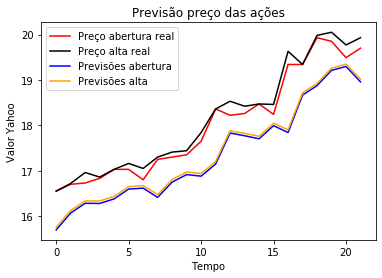

In [25]:
plt.plot(preco_real_close, color='red', label='Preço abertura real')
plt.plot(preco_real_high, color='black', label='Preço alta real')
plt.plot(previsoes[:, 0], color='blue', label='Previsões abertura')
plt.plot(previsoes[:, 1], color='orange', label='Previsões alta')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()